In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/test_Jan22.csv')

# Нужно проверить гипотезы о значимости признаков feature1 и feature2 (понять дают ли эти признаки какую-либо информацию для целевой переменной).

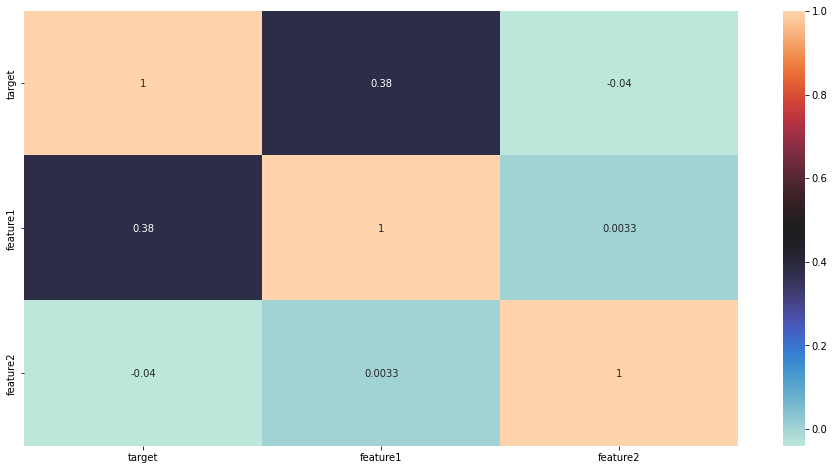

In [ ]:
# Для начала построим диаграмму корреляции:
plt.figure(figsize=(16, 8))
sns.heatmap(test[['target', 'feature1', 'feature2']].corr(), annot=True, cmap='icefire')

# видим, что сильнее с таргетом коррелирует фит1, по крайней мере по сравнению с фит2. Между собой признаки коррелируют очень слабо.
# значение корреляции от 0.3 до 0.5, по Пирсону это умеренная корреляция.

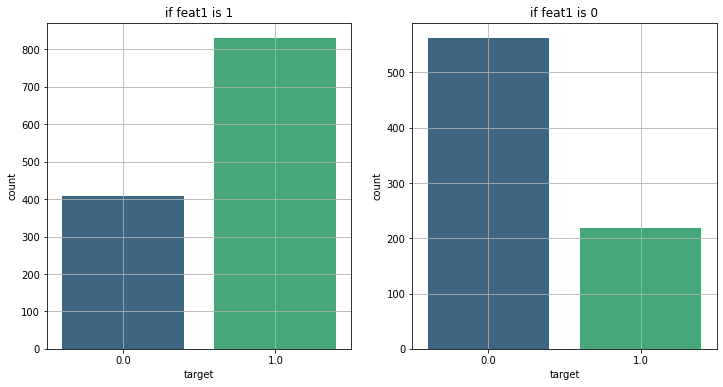

In [ ]:
# Выдвинем гипотезу, что фит1 влиет на таргет. Проверим, с помощью простой диаграммы:
if_feat1_is_one = test[test['feature1'] == 1]['target'].value_counts().reset_index()
if_feat1_is_zero = test[test['feature1'] == 0]['target'].value_counts().reset_index()
if_feat1_is_one.rename(columns={'index':'target', 'target':'count'}, inplace=True)
if_feat1_is_zero.rename(columns={'index':'target', 'target':'count'}, inplace=True)

fig, axes = plt.subplots(figsize=(12,6), ncols=2, nrows=1)

axes[0] = sns.barplot(data=if_feat1_is_one, x='target', y='count', ax=axes[0], palette='viridis')
axes[1] = sns.barplot(data=if_feat1_is_zero, x='target', y='count', ax=axes[1], palette='viridis')

for i, title in enumerate(['1', '0']):
  axes[i].set_title(f'if feat1 is {title}')
  axes[i].grid()

# видно, что положительных таргетов при фит1=1 в 2 раза больше. При фит1=0 положительных таргетов меньше, более чем в 2 раза. Гипотеза верна.

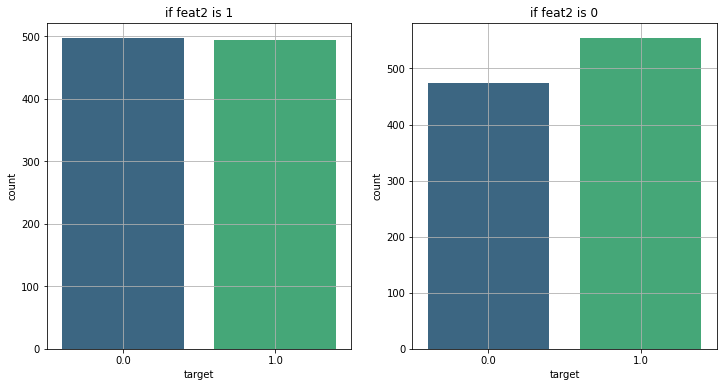

In [ ]:
# Выдвинем гипотезу, что фит2 влиет на таргет. Проверим точно так же:
if_feat2_is_one = test[test['feature2'] == 1]['target'].value_counts().reset_index()
if_feat2_is_zero = test[test['feature2'] == 0]['target'].value_counts().reset_index()
if_feat2_is_one.rename(columns={'index':'target', 'target':'count'}, inplace=True)
if_feat2_is_zero.rename(columns={'index':'target', 'target':'count'}, inplace=True)

fig, axes = plt.subplots(figsize=(12,6), ncols=2, nrows=1)

axes[0] = sns.barplot(data=if_feat2_is_one, x='target', y='count', ax=axes[0], palette='viridis')
axes[1] = sns.barplot(data=if_feat2_is_zero, x='target', y='count', ax=axes[1], palette='viridis')

for i, title in enumerate(['1', '0']):
  axes[i].set_title(f'if feat2 is {title}')
  axes[i].grid()

# Здесь видим, что при фит2=1 положит. и отрицат. таргетов поровну, при фит2=0 кол-во положит. таргетов лишь слегка превышает отрицательные. Таким образом гипотеза о том, что фит2
# влияет на таргет не подтвердилась. Корреляционной диаграмме в данном случае можно доверять.

In [ ]:
test.dropna(inplace=True)

## Статистическая проверка

In [ ]:
# объединим по разнице значений для разных признаков
feat_one_is_one = test[test['feature1'] == 1]['target']
feat_one_is_zero = test[test['feature1'] == 0]['target']

feat_two_is_one = test[test['feature2'] == 1]['target']
feat_two_is_zero = test[test['feature2'] == 0]['target']

In [ ]:
# найдем фактическое p-value, разницу между новым вариантом и старым. (новый будет тот, где фит1 = 1)
p_value = feat_one_is_one.mean() - feat_one_is_zero.mean()
p_value # само  по себе значение уже большое, т ч скорей всего признак влияет

0.40559604093060886

In [ ]:
# H0 - разницы в значении признака нет
# Н1 - разница есть
# отвергнем Н0 если результат бутстрэпа(цикл ниже) будет < 0.05 (ур-я значимости)
import numpy as np
import random
N = 1000 # мин граница статистической значимости
random.seed(17)
differences = np.zeros((1, N))
for i in range(0, N):
  s1 = random.choices(feat_one_is_zero.values, k = len(feat_one_is_zero))
  s2 = random.choices(feat_one_is_one.values, k = len(feat_one_is_one))
  p1 = np.mean(s1)
  p2 = np.mean(s2)
  differences[0][i] = p2 - p1

diff_cent = differences - np.mean(differences) # центровка относительно нуля.

In [ ]:
# Ни одного значения, больше или равного p_value (результат бутстрэпа). 0 < 0.05 -> Н0 отвергаем и разница есть.
(diff_cent >= p_value).sum()

0

In [ ]:
# Проверим точно так же и второй признак
p_value = feat_two_is_one.mean() - feat_two_is_zero.mean()
p_value # здесь значение очень маленькое, ожидаем, что разницы не будет

-0.04291034608047961

In [ ]:
# H0 - разницы в значении признака нет
# Н1 - разница есть
random.seed(17)
differences = np.zeros((1, N))
for i in range(0, N):
  s1 = random.choices(feat_two_is_zero.values, k = len(feat_two_is_zero))
  s2 = random.choices(feat_two_is_one.values, k = len(feat_two_is_one))
  p1 = np.mean(s1)
  p2 = np.mean(s2)
  differences[0][i] = p2 - p1

diff_cent = differences - np.mean(differences)

In [ ]:
(diff_cent <= p_value).sum() # "<=" т. к. p_value < 0
# здесь видим не ноль. 74/1000 = 0.074. 0.074 > 0.05 -> H0 не отвергаем. Разницы в значении признака нет.

74

# Нужно написать код для генерации следующих колонок:
1. events_ordinal_number - порядковый номер события
2. second_event_time - время второго события
3. loan_ordinal_number - порядковый номер займа. Считается как для займов так и для заявок. Заявка всегда имеет номер займа, на который она подается. Если перед получением первого займа было 5 заявок, то все они будут иметь значение признака 1
4. events_time_diff - разница во времени между событиями
5. previous_loans_max_amount - максимальная сумма предыдущего займа.

Все вышеуказанные колонки уже есть в датасете, что дополнительно поможет вам понять, как они считаются.  Все признаки считаются для уникальных user_id, поэтому для большего понимания посмотрите на значения признаков в таблице для одного user_id. Нас интересует именно код, который вы напишете для генерации признаков, итоговый датасет высылать не обязательно

In [ ]:
import pandas as pd

test = pd.read_csv('/content/drive/MyDrive/test_Jan22.csv')
test.sort_values(by=['user_id', 'events_ordinal_number'], inplace=True)
test['time'] = pd.to_datetime(test['time'])

In [ ]:
#@title Пункт 1. events_ordinal_number - порядковый номер события
val = test.groupby(['user_id'])['time'].apply(lambda x: [list(x).index(i) + 1 for i in list(x)]).reset_index()
val = val.explode('time')

test['check_1'] = val['time'].values
test[test['user_id'] == 123][['events_ordinal_number', 'check_1']]

In [ ]:
#@title Пункт 2. second_event_time - время второго события

val2 = test.groupby('user_id')['time'].apply(list).reset_index()
val2['time'] = val2['time'].apply(lambda x: x[1:2] * len(x))
val2 = val2.explode('time')

# test.sort_values(by=['user_id', 'events_ordinal_number'], inplace=True)
test['check_2'] = val2['time'].values
test[test['user_id'] == 100][['second_event_time', 'check_2']]

In [ ]:
#@title Пункт 3. loan_ordinal_number - порядковый номер займа.
def func(x):
  lo = []
  start = 1
  for i in range(len(x)):
    lo.append(start)
    if x[i] == 'loan':
      start += 1
  return lo

val3 = test.groupby('user_id')['type'].apply(list).reset_index()
val3['type'] = val3['type'].apply(func)
val3 = val3.explode('type')

test['check_3'] = val3['type'].values
test[test['user_id'] == 97][['type', 'loan_ordinal_number', 'check_3']]

In [ ]:
#@title Пункт 4. events_time_diff - разница во времени между событиями
def func(x):
  li = []
  for i in range(len(x)):
    m = x[i] - x[i-1]
    if m.days < 0:
      li.append('NaN')
    else:
      li.append(m)
  return li

val4 = test.groupby('user_id')['time'].apply(list).reset_index()
val4['time'] = val4['time'].apply(func) # надеюсь это "средствами pandas"?
val4 = val4.explode('time')

test['check_4'] = val4['time'].values
test[test['user_id'] == 222][['events_time_diff', 'check_4']]

In [ ]:
#@title Пункт 5. previous_loans_max_amount - максимальная сумма предыдущего займа.
def func(x, y):
  lu = [None]
  appender = None
  for i, row in enumerate(x):
    if row == 'loan':
      appender = y[i]
    lu.append(appender)
  return lu[:-1]

probe1 = test.groupby(['user_id'])['type'].apply(list).reset_index()
probe2 = test.groupby(['user_id'])['amount'].apply(list).reset_index()
val5 = probe1.merge(probe2, on='user_id')
val5['check_5'] = val5[['type', 'amount']].apply(lambda x: func(x['type'], x['amount']), axis=1)

test['check_5'] = val5.explode('check_5')['check_5'].values
test[test['user_id'] == 782][['previous_loans_max_amount', 'check_5']]

,previous_loans_max_amount,check_5
531,NaN,None
3620,14233.0,14233
3772,14233.0,14233
4033,14233.0,14233
4149,14233.0,14233
4283,14612.0,14612
5439,15307.0,15307
6028,15307.0,15307
9038,15307.0,15307
9202,15307.0,15307


In [ ]:
test

,time,user_id,type,amount,target,feature1,feature2,events_ordinal_number,second_event_time,loan_ordinal_number,events_time_diff,previous_loans_max_amount,check_1,check_2,check_3,check_4,check_5
186,2001-01-08 18:00:00,0,loan,16018,1.0,0,1,1,2001-01-16 13:00:00,1,NaN,NaN,1,2001-01-16 13:00:00,1,NaT,None
373,2001-01-16 13:00:00,0,loanRequest,15268,NaN,0,1,2,2001-01-16 13:00:00,2,7 days 19:00:00,16018.0,2,2001-01-16 13:00:00,2,7 days 19:00:00,16018
481,2001-01-21 01:00:00,0,loanRequest,14421,NaN,0,1,3,2001-01-16 13:00:00,2,4 days 12:00:00,16018.0,3,2001-01-16 13:00:00,2,4 days 12:00:00,16018
602,2001-01-26 02:00:00,0,loanRequest,15738,NaN,0,0,4,2001-01-16 13:00:00,2,5 days 01:00:00,16018.0,4,2001-01-16 13:00:00,2,5 days 01:00:00,16018
1229,2001-02-21 05:00:00,0,loanRequest,14908,NaN,1,1,5,2001-01-16 13:00:00,2,26 days 03:00:00,16018.0,5,2001-01-16 13:00:00,2,26 days 03:00:00,16018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3525,2001-05-27 21:00:00,999,loan,14753,0.0,0,1,5,2001-03-14 11:00:00,2,31 days 22:00:00,15299.0,5,2001-03-14 11:00:00,2,31 days 22:00:00,15299
6342,2001-09-22 06:00:00,999,loanRequest,13224,NaN,1,1,6,2001-03-14 11:00:00,3,117 days 09:00:00,14753.0,6,2001-03-14 11:00:00,3,117 days 09:00:00,14753
6474,2001-09-27 18:00:00,999,loanRequest,15090,NaN,1,1,7,2001-03-14 11:00:00,3,5 days 12:00:00,14753.0,7,2001-03-14 11:00:00,3,5 days 12:00:00,14753
6925,2001-10-16 13:00:00,999,loanRequest,14717,NaN,0,0,8,2001-03-14 11:00:00,3,18 days 19:00:00,14753.0,8,2001-03-14 11:00:00,3,18 days 19:00:00,14753
